In [1]:
import cv2 as cv
import numpy as np
import numpy.linalg as la
import scipy as sp
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import scipy.optimize as sopt
from mpl_toolkits.axisartist import (
    angle_helper, Subplot, SubplotHost, ParasiteAxesAuxTrans)
from mpl_toolkits.axisartist.grid_helper_curvelinear import (
    GridHelperCurveLinear)

# Simple image displaying

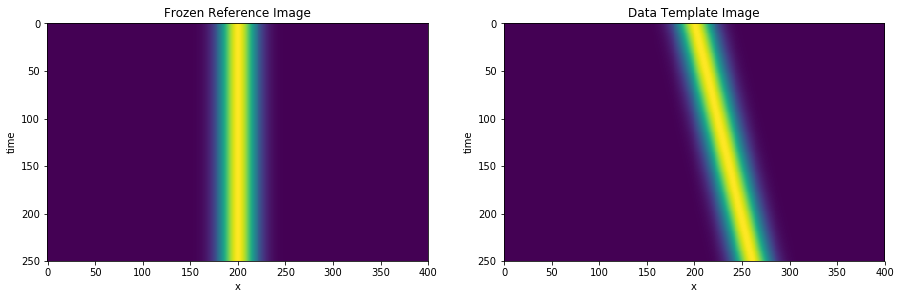

In [20]:
w = 400
h = 250

R = np.zeros((h, w))
T_raw = np.zeros((h, w))

# Generate sample wave equation solution (c=1) and standing wave
for i in range(h):
    for j in range(w):
        x, t = 2 * (j - w / 2) / w, i / h
        R[i][j] = np.exp(-100 * x ** 2)
        T_raw[i][j] = np.exp(-100 * (x - t * 0.3) ** 2)
        

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.xlabel('x')
plt.ylabel('time')
plt.title('Frozen Reference Image')
plt.imshow(R)
plt.subplot(1, 2, 2)
plt.xlabel('x')
plt.ylabel('time')
plt.title('Data Template Image')
plt.imshow(T_raw)

# Function definitions

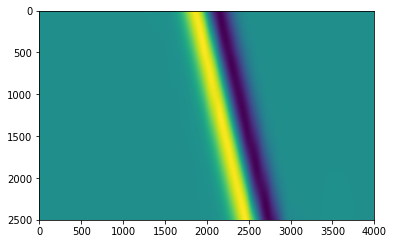

In [3]:
x = np.arange(w)
y = np.arange(h)
T = sp.interpolate.RectBivariateSpline(x, y, T_raw.T, s=1e-1) # Interpolation of our image, transposed to be on x/y

# Plot the interpolation on a new grid to ensure it worked
Img = T(np.linspace(0, w-1, w*10), np.linspace(0, h-1, h*10), dx=1) # evaluation of d/dx on the grid
plt.imshow(Img.T) # drawing the interpolation, transposed so x is column, y is rows
plt.show()

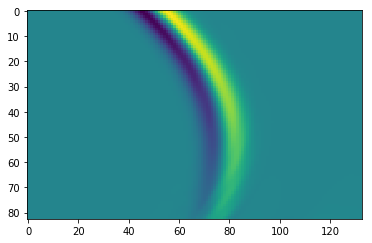

In [4]:
# Quadratically transforms interpolated function T from parameters p and returns new function that works on integers/numpy arrays
# p = p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12
# p3-p12 form a matrix:
# (p3  p4  p5  p6  p7 )
# (p8  p9  p10 p11 p12)
# Which defines a transformation on quadratic x/y polynomials
# (p1, p2) is translation in (x, y)
def trafo(T, p, w, h):
    # The jacobian of the mapping
    def J(x, y):
        return np.array([[p[2] + 2 * p[4] * x + p[6] * y, p[3] + 2 * p[5] * y + p[6] * x], \
                         [p[7] + 2 * p[9] * x + p[11] * y, p[8] + 2 * p[10] * y + p[11] * x]])
    
    def T_map(x, y):
                
        # Translate to center
        x0 = (x - w // 2) / w
        y0 = (y - h // 2) / h

        #Apply transformation and translation
        x = (p[2] * x0 + p[3] * y0 + p[4] * x0 ** 2 + p[5] * y0 ** 2 + p[6] * x0 * y0)*w + w // 2 - p[0]
        y = (p[7] * x0 + p[8] * y0 + p[9] * x0 ** 2 + p[10] * y0 ** 2 + p[11] * x0 * y0)*h + h // 2 - p[1]
        
        return x, y
    
    def ev(x, y, dx=0, dy=0):
        
        x, y = T_map(x, y)
        
        if dx == 0 and dy == 0:
            return T(x, y)
        elif dx == 1 and dy == 0:
            jac = J(x, y)
            return T(x, y, dx=1) * jac[0][0] + T(x, y, dy=1) * jac[1][0]
        elif dx == 0 and dy == 1:
            jac = J(x, y)
            return T(x, y, dx=1) * jac[0][1] + T(x, y, dy=1) * jac[1][1]
        # This case is depracated, it is based on a linear transform
#         elif dx == 1 and dy == 1:
#             return p[3] * (T(x, y, dx=2) * p[2] + T(x, y, dx=1, dy=1) * p[0]) + p[1] * (T(x, y, dx=2) * p[2] + T(x, y, dx=1, dy=1) * p[0]) # Second derivatives on f/g are 0
        return 0
        
    def mapped_T(x, y, dx=0, dy=0):
        if isinstance(x, (int, float)) and isinstance(y, (float, int)):
            return ev(x, y, dx=dx, dy=dy)
        elif isinstance(x, np.ndarray) and isinstance(y, np.ndarray):
            # We need to handle broadcasting ourselves to avoid skewing
            out_grid = np.zeros((len(x), len(y)))
            for xi in range(len(x)):
                for yi in range(len(y)):
                    out_grid[xi][yi] = ev(x[xi], y[yi], dx=dx, dy=dy)
            return out_grid
            
    return mapped_T, T_map, J

T_transformed, T_map, J = trafo(T, [0, 0, 1, 0, -0.1, 0.5, 0.1, -0.2, 1, 0, 0.2, -0.3], w, h) # This deforms the input
# Plot the transformed T
Z = T_transformed(np.linspace(0,w-1, w // 3), np.linspace(0, h-1, h//3), dx=1) # evaluation of the function on the grid
plt.imshow(Z.T) # drawing the function
plt.show()

In [5]:
# Determine cost of transformation based on the conditioning of the jacobian
# Calculates in input space from (0, w) x (0, h)
def cost_cond(T_map, J, w, h, step=10):
    sum_cost = 0
    for xi in range(0, w, step):
        for yi in range(0, h, step):
            x, y = T_map(xi, yi)
            sum_cost += la.cond(J(x, y))
    return sum_cost / (w * h / (step * step))

# Determine cost of transformation based on determinant of jacobian
def cost_det(T_map, J, w, h, step=10):
    sum_cost = 0
    for xi in range(0, w, step):
        for yi in range(0, h, step):
            x, y = T_map(xi, yi)
            sum_cost += la.det(J(x, y))
    return sum_cost / (w * h / (step * step))

In [6]:
# Helper method for grid plotting
def plot_grid(ax, gridx,gridy, **kwargs):
    for i in range(gridx.shape[0]):
        ax.plot(gridx[i,:], gridy[i,:], **kwargs)
    for i in range(gridx.shape[1]):
        ax.plot(gridx[:,i], gridy[:,i], **kwargs)
        
# Map inversion
def inv_map(c_map, grid_x, grid_y):
    o_grid_x = []
    o_grid_y = []
    for yi in range(len(grid_y)):
        o_grid_x.append([])
        o_grid_y.append([])
        for xi in range(len(grid_x)):
            x, y = grid_x[yi][xi], grid_y[yi][xi]
            soln = sopt.fsolve(lambda z:np.array(c_map(z[0], z[1])) - np.array((x, y)), np.array([x, y]))
            o_grid_x[-1].append(soln[0])
            o_grid_y[-1].append(soln[1])
    return np.array(o_grid_x), np.array(o_grid_y)
        

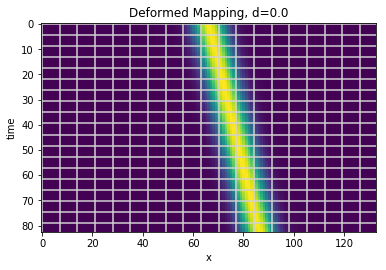

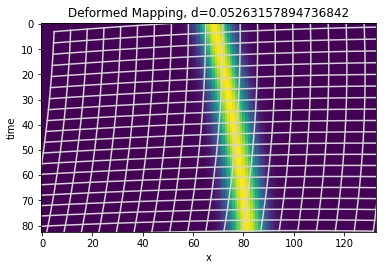

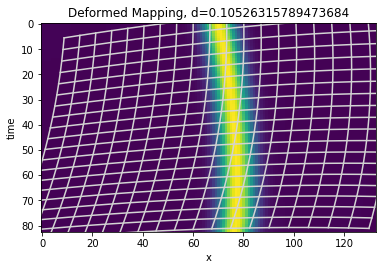

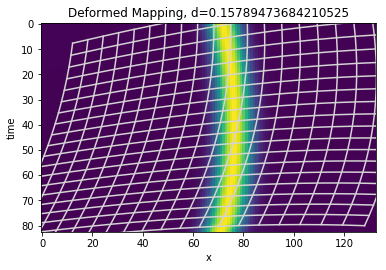

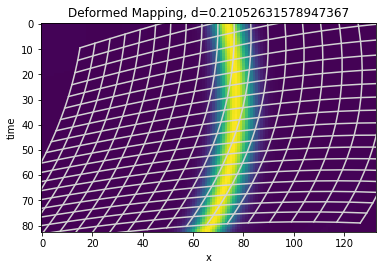

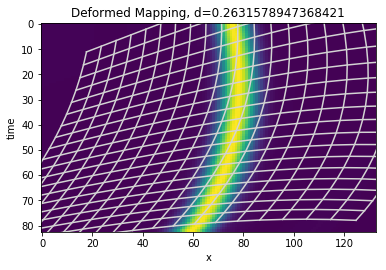

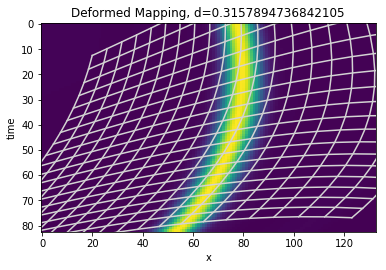

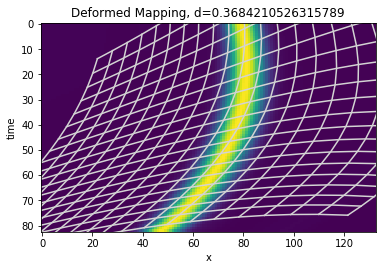

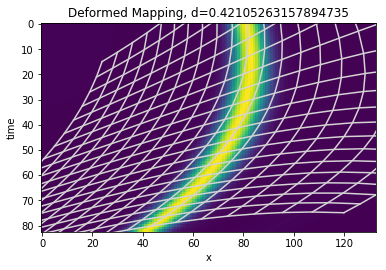

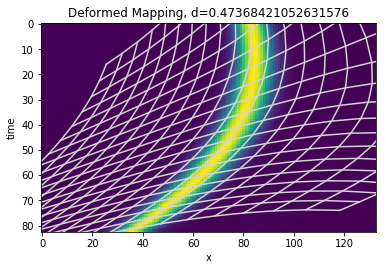

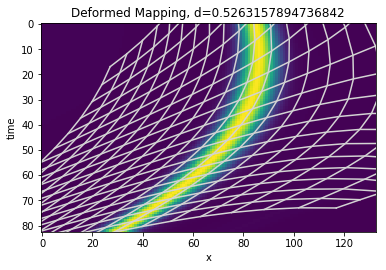

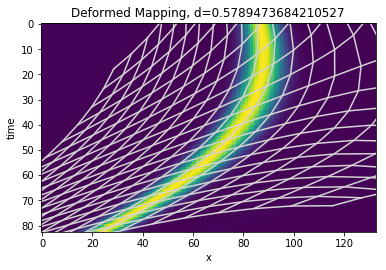

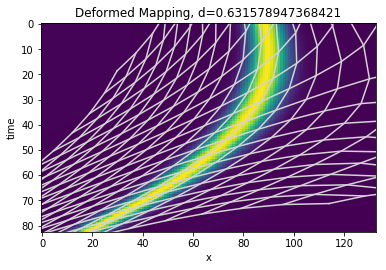

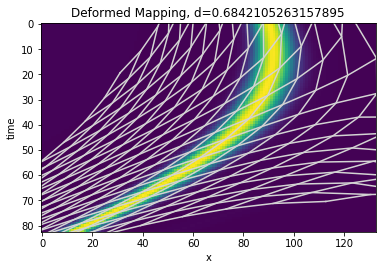

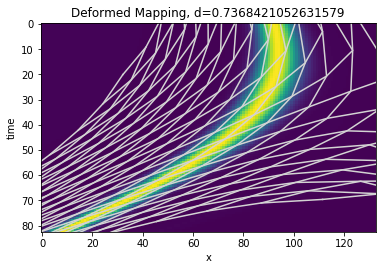

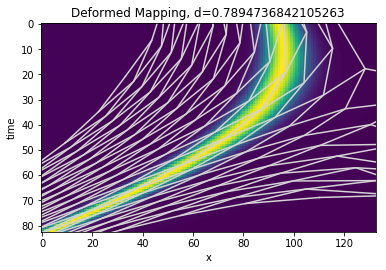

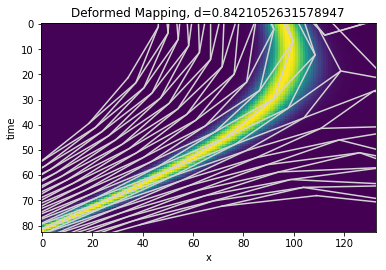

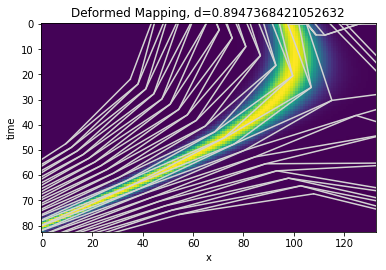

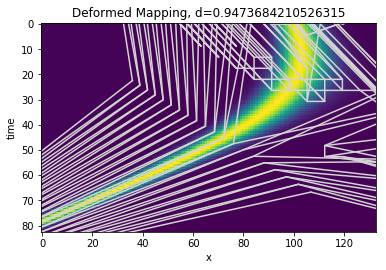

In [22]:
# Plotting cost vs. deformation
T_defs = []
rnge = 19
for i in range(rnge):
    d = i / rnge
    T_new, T_map, T_J = trafo(T, [0, 0, 1, d, -d, d, -d, d, 1, -d, d, -d], w, h) # This deforms the input
    T_defs.append([T_new, T_map, T_J])
    fact = 3
    wspace = np.linspace(0,w-1, w // fact)
    hspace = np.linspace(0, h-1, h // fact)
    Z = T_new(wspace, hspace) # evaluation of the function on the grid
    
    fig, ax = plt.subplots()
    
    grid_x,grid_y = np.meshgrid(np.linspace(0, w, 20),np.linspace(0, h,20))

    distx, disty = inv_map(T_map, grid_x,grid_y)
    distx /= fact
    disty /= fact
    plot_grid(ax,distx, disty, color="lightgray")
    ax.imshow(Z.T) # drawing the function
    plt.xlabel('x')
    plt.ylabel('time')
    plt.title('Deformed Mapping, d=' + str(d))
    
    plt.show()

In [23]:
cond_costs = [cost_cond(T_defs[i][1], T_defs[i][2], w, h) for i in range(len(T_defs))]
det_costs = [cost_det(T_defs[i][1], T_defs[i][2], w, h) for i in range(len(T_defs))]

# Plotting cond(J)/det(J) costs

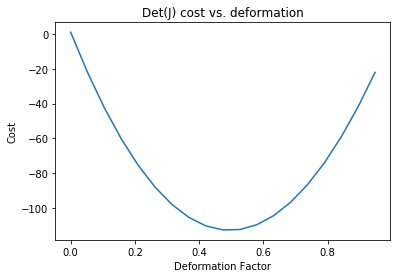

In [24]:
plt.plot(np.arange(rnge) / rnge, det_costs)
plt.xlabel('Deformation Factor')
plt.ylabel('Cost')
plt.title('Det(J) cost vs. deformation')
plt.show()

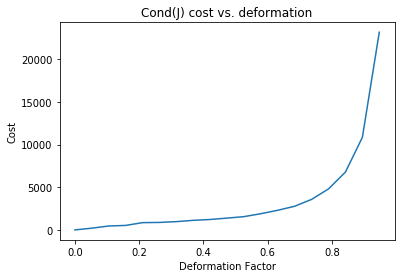

In [25]:
plt.plot(np.arange(rnge) / rnge, cond_costs)
plt.xlabel('Deformation Factor')
plt.ylabel('Cost')
plt.title('Cond(J) cost vs. deformation')
plt.show()

In [11]:
def SSD(im1, im2):
    return np.sum((np.array(im1)[:,:]-np.array(im2)[:,:])**2)

def obj_func(p):
    T_transformed, T_map, J = trafo(T, p, w, h) # This deforms the input
    Z = T_transformed(np.arange(0, w - 1, 10), np.arange(0, h - 1, 10)) # evaluation of the function on the grid
    return SSD(Z, R_sparse) + Reg * cost_cond(T_map, J, w, h)

Reg = 1e-5
R_sparse = np.array([[R[i * 10][j * 10] for i in range((h - 1) // 10 + 1)] for j in range((w - 1) // 10 + 1)])

In [12]:
p_best = sopt.minimize(obj_func, np.array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]), method='BFGS')

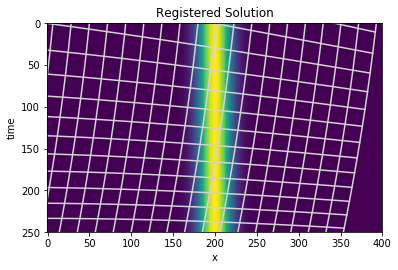

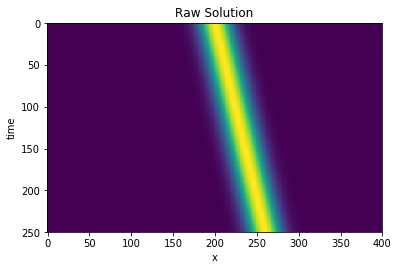

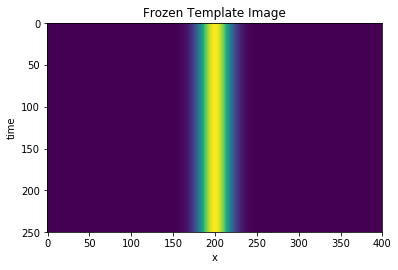

In [15]:
T_best, T_map_best, J_best = trafo(T, p_best.x, w, h)
Z_best = T_best(np.arange(0, w, 1), np.arange(0, h, 1))
fig, ax = plt.subplots()

grid_x,grid_y = np.meshgrid(np.linspace(0, w, 20),np.linspace(0, h,20))

distx, disty = inv_map(T_map_best, grid_x,grid_y)
# distx /= fact
# disty /= fact
plot_grid(ax,distx, disty, color="lightgray")
ax.imshow(Z_best.T)
plt.xlabel('x')
plt.ylabel('time')
plt.title('Registered Solution')
plt.show()
plt.imshow(T_raw)
plt.xlabel('x')
plt.ylabel('time')
plt.title('Raw Solution')
plt.show()
plt.imshow(R)
plt.xlabel('x')
plt.ylabel('time')
plt.title('Frozen Template Image')
plt.show()